<a href="https://colab.research.google.com/github/jasonhadiputra/differential-equations-tools/blob/master/Intro_to_DE_Tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: [Jason Hadinata](https://www.linkedin.com/in/jasonhadiputra/).

# INITIALISE

In [ ]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
from scipy.integrate import *

init_printing()

# SLOPE FIELD

In [ ]:
VIEWPORT_SF = (0,15),(0,6)

def f(x,y):
  return y*(y-2)*(y-4)

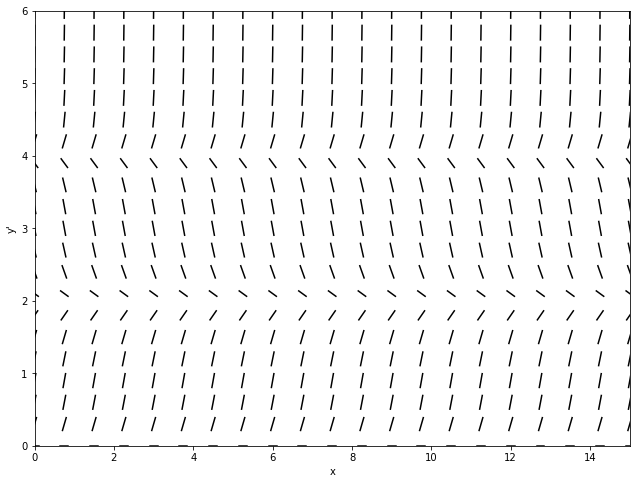

In [ ]:
#@title  { run: "auto", vertical-output: true, display-mode: "form" }
ratio = 0 #@param {type:"number"}

DENSITY = 20
LENGTH = 1/1.5

X_VAR, Y_VAR = "x", "y"
NUMBER_OF_VERTICES = 20

# Setting viewport
INIT_X = VIEWPORT_SF[0][0]
END_X = VIEWPORT_SF[0][1]
INIT_Y = VIEWPORT_SF[1][0]

X_LENGTH = END_X - INIT_X
if isinstance(ratio, float):
  END_Y = INIT_Y + ratio * X_LENGTH
else:
  END_Y = VIEWPORT_SF[1][1]

Y_LENGTH = END_Y - INIT_Y

SCALAR = LENGTH * np.minimum(X_LENGTH, Y_LENGTH)/NUMBER_OF_VERTICES

# Function to rotate 'stick' lying on the x-axis
def rotate(theta):
  return (np.matrix([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]]) *
          np.matrix([[0.5,-0.5],
                     [0.0, 0.0]]))

if Y_LENGTH/X_LENGTH < 1/2:
  plt.rcParams["figure.figsize"] = (4/3 * 8,8)
elif Y_LENGTH/X_LENGTH <= 1:
  plt.rcParams["figure.figsize"] = (8 * X_LENGTH/Y_LENGTH,8)
else:
  plt.rcParams["figure.figsize"] = (4/3 * 8,8)

plt.xlim([INIT_X,END_X])
plt.ylim([INIT_Y,END_Y])

plt.xlabel(X_VAR)
plt.ylabel(f'{Y_VAR}\'')

for i in np.linspace(INIT_X, END_X, NUMBER_OF_VERTICES+1):
  for j in np.linspace(INIT_Y, END_Y, NUMBER_OF_VERTICES+1):
    # Ask for the angle of rotation
    theta = np.arctan(f(i,j))

    # Ask for the rotated and scaled 'stick'
    p = SCALAR * rotate(np.arctan(f(i,j)))

    # Shift the coordinates
    p = p + np.matrix([[i,i],[j,j]])

    # Plot the field
    plt.plot(p[0,:].getA1(), p[1,:].getA1(), 'k')

plt.show()

# PHASE PLANE

In [ ]:
VIEWPORT_PP = (-100,100),(-100,100)

A = np.array([[0.5,-1],
              [1,0.5]])

def x_(x,y):
  return np.array([2*x-x*y,
                   -5*y+x*y])

# Note: x0 will be transposed
# Ignored if draw_x0 is unchecked
x0_T = np.array([[50,50],
                 [0,2],
                 [0,3]])

Blue           Red           Green
-------Increasing Magnitude------>




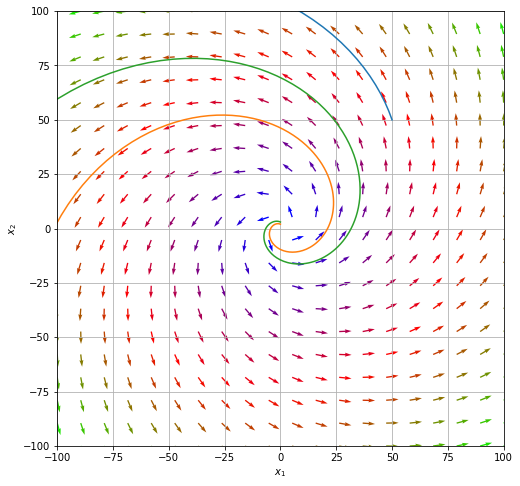

In [ ]:
#@title Draw the Phase Plane { run: "auto", vertical-output: true, display-mode: "form" }
source = "A" #@param ["A", "x_"]
draw_eigen = True #@param {type:"boolean"}
draw_x0 = True #@param {type:"boolean"}
end_t = 53 #@param {type:"slider", min:0, max:100, step:1}
length_representation = "colour" #@param ["colour", "length"]

n_x2 = 20

# Setting viewport
(init_x1,end_x1),(init_x2,end_x2) = VIEWPORT_PP
length_x1,length_x2 = (end_x1 - init_x1),(end_x2 - init_x2) 

ratio = length_x1/length_x2
if ratio < 1/2 or ratio > 1:
  ratio = 16/9
plt.rcParams["figure.figsize"] = (ratio*8,8)

# Make x'(t) as a vector
if source == "A":
  def x_(x1,x2):
    return np.array([A[0,0]*x1 + A[0,1]*x2,
                     A[1,0]*x1 + A[1,1]*x2])

# Draw the phase plane
x1 = np.linspace(init_x1,end_x1,int(ratio*n_x2))
x2 = np.linspace(init_x2,end_x2,n_x2)

X1,X2 = np.meshgrid(x1,x2)
# The arrow directions
U,V = x_(X1,X2)

if length_representation == 'colour':
  # To normalise the arrows
  length = np.sqrt(U**2 + V**2)
  plt.quiver(X1,X2,U/length,V/length,length,cmap = 'brg')
  
  print("Blue           Red           Green")
  print("-------Increasing Magnitude------>")
  print()
else:
  plt.quiver(X1,X2,U,V)

if source == "A":
  plt.xlabel('$x_1$');plt.ylabel('$x_2$')
elif source == "x_":
  plt.xlabel('$x$');plt.ylabel('$y$')

plt.xlim(init_x1,end_x1);plt.ylim(init_x2,end_x2)

if draw_eigen and source == "A":
  # Output: w = eigenvalue, v = P
  w, v = np.linalg.eig(A)

  # Draw the eigenvectors, only if they're real
  if np.isreal(w[0]):
    # Colour code based on behaviour and draw
    if w[0] > w[1]:
      col = ['red','green']
    elif w[0] < w[1]:
        col = ['green','red']
    else:
      col = ['orange','orange']

    for i in range(len(w)):
      plt.plot(np.sqrt(2)*v[0,i]*np.array([init_x1,end_x1]),np.sqrt(2)*v[1,i]*np.array([init_x2,end_x2]),
               color = col[i], label = f'exp({np.around(w[i],3)}t)')

    plt.legend(loc='best')
  else:
    print("Warning: The eigenvalues are not real.")
    print()

if draw_x0:
  # Transpose
  x0 = x0_T.T
  sol = []

  # Let x = <x1,x2>
  def model(x,t):
    x1, x2 = x
    dxdt = x_(x1,x2)
    return dxdt

  t = np.linspace(0,end_t,1000+1)
  # Check for every x0
  for i in range(x0.shape[1]): 
    sol.append(odeint(model, x0[:,i], t))
    plt.plot(sol[i][:,0],sol[i][:,1])

plt.grid()
plt.show()

In [ ]:
VIEWPORT_TP = (0,10),(-10,10)

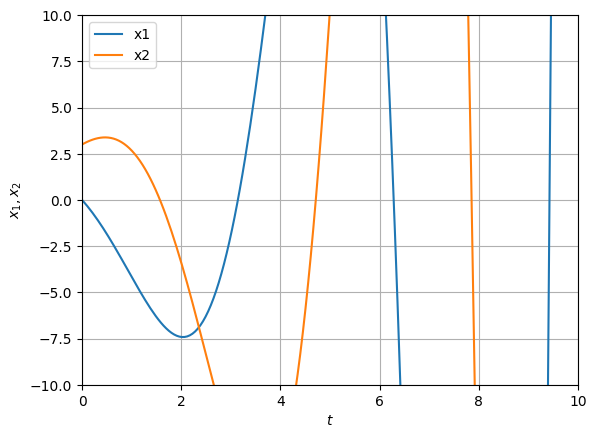

In [ ]:
#@title Draw The Trajectories { run: "auto", vertical-output: true, display-mode: "form" }
which = 2 #@param {type:"integer"}
init_x = VIEWPORT_TP[0][0]
end_x = VIEWPORT_TP[0][1]
init_y = VIEWPORT_TP[1][0]
end_y = VIEWPORT_TP[1][1]

plt.style.use(['default'])

plt.plot(t,sol[which][:,0],label='x1')
plt.plot(t,sol[which][:,1],label='x2')

plt.xlabel('$t$')
plt.ylabel('$x_1,x_2$')

plt.xlim(init_x,end_x)
plt.ylim(init_y,end_y)

plt.legend(loc='best')

plt.grid()
plt.show()

# FOURIER SERIES

In [ ]:
t = symbols('t', real = True)

init_t = -1
end_t = 1

f = Piecewise((0,(init_t <= t) & (t < 0)),
              (t,(0 <= t) & (t < end_t)))

ff = fourier_series(f,(t,init_t,end_t))

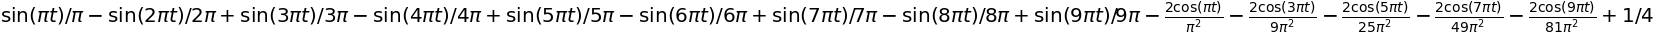

In [ ]:
ff.truncate(10)

In [ ]:
VIEWPORT_FS = (-5,5),(-5,5)

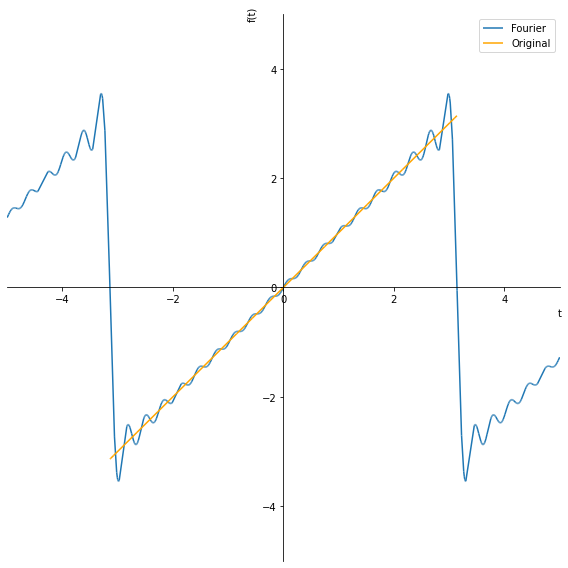

In [ ]:
#@title Draw the Fourier Series { run: "auto", vertical-output: true, display-mode: "form" }
n_term = 19 #@param {type:"slider", min:0, max:100, step:1}
show_original = True #@param {type:"boolean"}

# Setting viewport
(init_x,end_x),(init_y,end_y) = VIEWPORT_FS
length_x,length_y = (end_x - init_x),(end_y - init_y) 

ratio = length_x/length_y
if ratio < 1/2 or ratio > 1:
  ratio = 16/9

p1 = plot(ff.truncate(n_term),(t,init_x,end_x),xlabel='t',ylabel='f(t)',
          axis_center='center',xlim=(init_x,end_x),ylim=(init_y,end_y),
          size=(ratio*8,8),show=False,label='Fourier')

if show_original:
  p2 = plot(f,show=False,line_color='orange',label='Original')
  p1.extend(p2)

p1.legend = True
p1.show()

# HEAT/WAVE EQUATION

In [ ]:
boundary_condition = np.array([[1,0],
                               [1,0]])

In [ ]:
np.arccos(0)

$u_{t}=\alpha^2 u_{xx}$

In [ ]:
#@title
n_term = 0 #@param {type:"slider", min:0, max:100, step:1}
L = 40 #@param {type:"number"}
alpha2 = 0 #@param {type:"number"}
t_end = 500 #@param {type:"number"}

VIEWPORT_PDE = (0,L),(-5,5)

# Setting viewport
(init_x,end_x),(init_u,end_u) = VIEWPORT_FS
length_x,length_u = (end_x - init_x),(end_u - init_u) 

ratio = length_x/length_u
if ratio < 1/2 or ratio > 1:
  ratio = 16/9

###
x = np.linspace(0,L,500+1)
t = np.linspace(0,t_end,500+1)
X,T = np.meshgrid(x,t)

U = 0
u0 = 100
k = 1
L = 50

for n in range(n_term):
  U = U + np.exp(-((2*n+1)*np.pi/L)**2*k*t)/(2*n+1)*np.sin((2*n+1)*np.pi*x/L)

U = 4*u0/np.pi*U

plt.show()

In [ ]:
np.arange(start=1/L, stop=n_term/L, step=1/L)

array([1, 3, 5])